# Training a classifier on a real dataset.

## Task:

We need to train a classifier that determines the type of bicycle on a small dataset of bicycle photos from public sources.

Analyse the data, select the appropriate tools and metrics to address this challenge.

You are allowed to use pre-trained models from torchvision.models.
Write a report about the results.

## Data

In [1]:
! wget http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
! unzip bt_dataset3.zip -d dataset

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Solution

In [3]:
import os
import abc
import time
import typing
import random
import warnings

import PIL
import tqdm
import torch
import wandb
import numpy
import pandas
import torchscan
import torchvision
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata
from torchvision.transforms import v2 as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


In [4]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

### Analyze the dataset

#### Class distribution

tensor([ 109,  115,  714, 1016,  336])


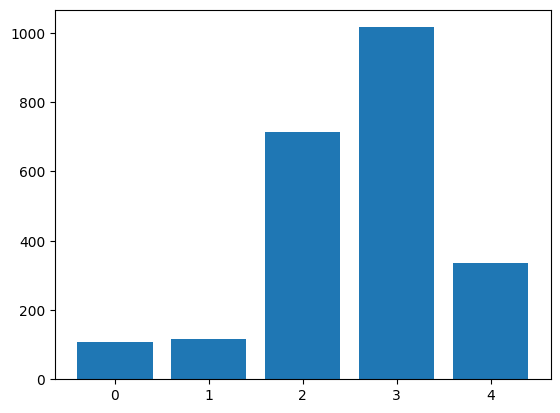

In [5]:
train_images = torchvision.datasets.ImageFolder("./dataset/train")
labels = numpy.array([ label for (image, label) in train_images ])
unique, counts = numpy.unique(labels, return_counts = True)
plt.bar(unique, counts)

# Save distribution for later use
class_counts = torch.tensor(counts)
print(class_counts)

Видно, что классы крайне несбалансированы, из-за чего в качестве целевой метрики accuracy будет иметь мало смысла. Воспользуемся средним значением F1-меры: эта метрика лучше показывает качество предсказаний при решении задачи классификации несбалансированного датасета.

#### Image size distribution

In [6]:
def print_distribution(dataset):
    min_size = numpy.array([ min(image.size) for (image, label) in dataset ])
    unique, counts = numpy.unique(min_size, return_counts = True)
    mean = numpy.mean(min_size)
    std = numpy.std(min_size)
    plt.bar(unique, counts)
    plt.plot([ mean, mean ], [ 0, numpy.max(counts) ], color = 'red', linestyle = 'dashed', label = 'mean')
    plt.legend()
    print({ 'Mean': mean, 'Std': std, 'Min': numpy.min(unique), 'Max': numpy.max(unique) })

{'Mean': 224.0646288209607, 'Std': 189.0633271542736, 'Min': 30, 'Max': 956}


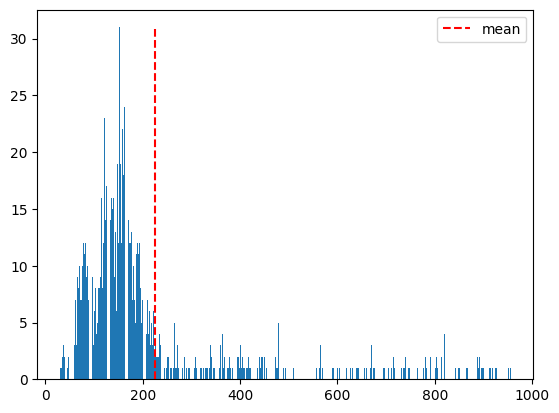

In [7]:
print_distribution(train_images)

Удалим очень маленькие и очень большие картинки из тестовой выборки. Они могут плохо влиять на процесс обучения

Images before: 2290
Images after: 2237
{'Mean': 220.43182834152884, 'Std': 178.09336510298968, 'Min': 57, 'Max': 895}


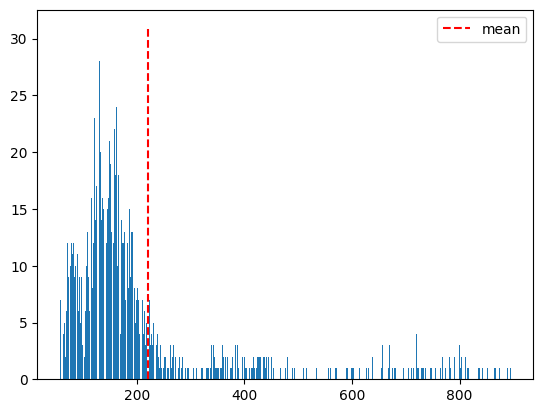

In [8]:
idx = [ i for i in range(len(train_images)) if 224 / 4 < min(train_images[i][0].size) < 224 * 4 ]
print('Images before: {}'.format(len(train_images)))
train_images = torchdata.Subset(train_images, idx)
print('Images after: {}'.format(len(train_images)))
print_distribution(train_images)

Средний размер картинок примерно равен 220. Скорее всего, предобученные на ImageNet модели, релизованные в torchvision, достаточно хорошо подходят для решения поставленной задачи.

### Dataset

#### Raw dataset

In [9]:
class MyDataset(torchdata.Dataset):
    def __init__(
            self,
            name: str,
            dataset: torchvision.datasets.ImageFolder,
            preload: bool = True,
            precalculate_transform: bool = True,
            transform: typing.Optional[transforms.Compose] = None
        ):
        self.name = name
        self.transform = None
        self.dataset = dataset
        self.precalculated_transform = None

        # The dataset is not that big, so we might want to load it into RAM beforehand
        if preload or precalculate_transform:
            if precalculate_transform:
                # We might also want to precalculate the transform
                self.precalculated_transform = transform
                self.transform = transform
                transform = None
            # If precalculate_transform is True, self.transform is set, and __getitem__ will apply the transforms
            self.images, self.targets = self.load_all("Preload {}".format(self.name))
        # If precalculate_transform is True, this will be None
        self.transform = transform

    def load_all(self, progress_bar: bool = False):
        images = [ ]
        targets = [ ]
        for record in (tqdm.tqdm(self, desc = progress_bar.ljust(25)) if progress_bar else self):
            images.append(record[0])
            targets.append(record[1])
        # If no transforms are applied, torch.stack(images) will fail
        try: return torch.stack(images), targets
        except: return images, targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if hasattr(self, 'images') and hasattr(self, 'targets'):
            # If the data has been preloaded, use it
            image, target = self.images[idx], self.targets[idx]
        else:
            # Access the source
            image, target = self.dataset[idx]
        # Apply the transform if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, target
    
    def channel_stats(self):
        images, _ = self.load_all() # Get the dataset as two tensors
        # Calculate the metrics
        mean = torch.mean(images, dim = [0, 2, 3])
        std = torch.std(images, dim = [0, 2, 3])
        return mean, std

In [10]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize(256),
    torchvision.transforms.v2.RandomCrop((224, 224)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

dataset = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
mean, std = dataset.channel_stats()
print(mean, std)
del dataset

Preload train            : 100%|██████████| 2237/2237 [00:04<00:00, 531.04it/s]


tensor([0.4059, 0.3909, 0.3978]) tensor([0.2065, 0.1991, 0.1992])


Preload train            : 100%|██████████| 2237/2237 [00:05<00:00, 439.50it/s]


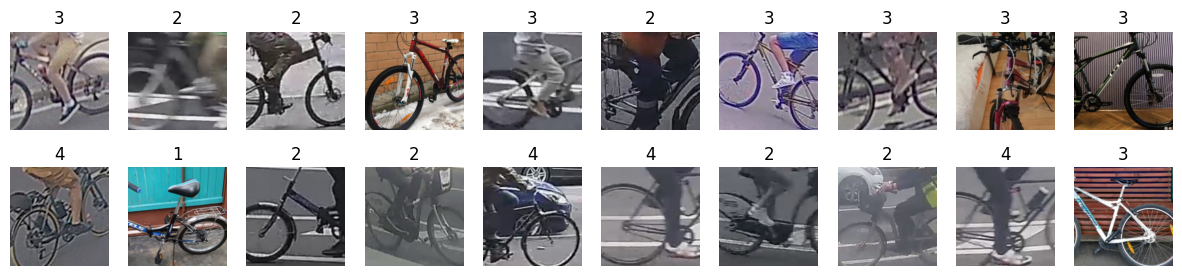

In [11]:
fix_random()

transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize(256),
    torchvision.transforms.v2.RandomCrop((224, 224)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

test_images = torchvision.datasets.ImageFolder("./dataset/val")
test_set = MyDataset("val", test_images, transform = transform, preload = True, precalculate_transform = True)
train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = [ 1., 1., 1. ])
])

# Display some samples from each dataset
def display_examples(dataset: torchdata.Dataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(label))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8))

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

del train_set
del test_set

#### Dataset of features

In [12]:
class FeaturesDataset(torchdata.StackDataset):
    def __init__(
            self,
            extractor_name: str,
            dataset: MyDataset,
            batch_size: int = 256,
            extractor_device: torch.device = device
        ):
        self.extractor_name = extractor_name
        self.name = 'Features for {} with {}'.format(dataset.name, extractor_name)

        # If it is already a dataset of features, return
        if isinstance(dataset, FeaturesDataset):
            return super().__init__(dataset)

        # https://github.com/pytorch/vision/issues/7744
        def get_state_dict(self, *args, **kwargs):
            kwargs.pop("check_hash")
            return torch.hub.load_state_dict_from_url(self.url, *args, **kwargs)
        torchvision.models._api.WeightsEnum.get_state_dict = get_state_dict

        # Load a pretrained model
        self.weights = torchvision.models.get_model_weights(extractor_name).DEFAULT
        self.extractor = torchvision.models.get_model(extractor_name, weights = self.weights)
        self.transform = self.weights.transforms()
        self.extractor_device = extractor_device

        # Remove last layer
        if hasattr(self.extractor, 'fc'): self.extractor.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.extractor, 'classifier'): self.extractor.classifier = torch.nn.Identity() # All others
        
        save_transform = dataset.transform if hasattr(dataset, 'transform') else None
        dataset.transform = None
        assert isinstance(dataset[0][0], PIL.Image.Image) # Without transforms it should return raw images
        dataset.transform = self.transform # Use transforms for pretrained model

        targets = [ ]
        features = [ ]
        self.extractor.to(self.extractor_device).eval() # Enter evaluation mode
        loader = torchdata.DataLoader(dataset, batch_size = batch_size) # Create a dataloader
        for images_batch, targets_batch in tqdm.tqdm(loader, desc = self.name.ljust(25)):
            with torch.no_grad():
                # Calculate features
                features_batch = self.extractor(images_batch.to(self.extractor_device))
                if features_batch.dim() == 4:
                    # Maybe apply adaptive average pooling if it is not built into the model
                    features_batch = torch.nn.functional.adaptive_avg_pool2d(features_batch, 1)
                # Flatten the output
                features.append(features_batch.detach().cpu().flatten(start_dim = 1))
                targets.append(targets_batch)

        # Free up the GPU
        self.extractor = self.extractor.to('cpu')
        if self.extractor_device.type == 'cuda': torch.cuda.empty_cache()
        elif self.extractor_device.type == 'mps': torch.mps.empty_cache()

        dataset.transform = save_transform # Restore transforms of the base dataset
        super().__init__(torch.cat(features), torch.cat(targets)) # Initialize StackDataset

In [13]:
class FeaturesCatDataset(torchdata.StackDataset):
    def __init__(self, *datasets: typing.List[FeaturesDataset]):
        self.name = datasets[0].name
        self.extractors = [ ]
        for dataset in datasets:
            assert len(dataset) == len(datasets[0])
            self.extractors.append(dataset.extractor_name)
        self.name = 'Features for {} with {}'.format(self.name, ', '.join(self.extractors))

        targets = [ ]
        features = [ ]
        for i in range(len(datasets[0])):
            item_features = [ ]
            item_target = datasets[0][i][1]
            for dataset in datasets:
                assert dataset[i][1] == item_target
                item_features.append(dataset[i][0])
            targets.append(item_target)
            features.append(torch.cat(item_features))

        super().__init__(torch.stack(features), torch.tensor(targets)) # Initialize StackDataset

### Classifier

In [14]:
class BaseClassifier(abc.ABC):
    @abc.abstractmethod
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError
    
    def calc_metrics(self, dataset: torchdata.Dataset, report: bool = False) -> dict:
        num_classes = self.output_shape[0] if hasattr(self, 'output_shape') else len(dataset.classes)
        batch_size = self.batch_size if hasattr(self, 'batch_size') else 512
        classes = torch.arange(num_classes)

        all_labels = torch.tensor([])
        all_predictions = torch.tensor([])
        all_scores = torch.empty((0, num_classes))
        loader = torchdata.DataLoader(dataset, batch_size = batch_size, shuffle = False)
        for data in loader:
            predictions, scores = self.predict(*data[:-1])
            all_labels = torch.cat([ all_labels, data[-1] ])
            all_scores = torch.cat([ all_scores, scores.detach().cpu() ])
            all_predictions = torch.cat([ all_predictions, predictions.detach().cpu() ])

        if report:
            print(sklearn.metrics.classification_report(all_labels, all_predictions, labels = classes))

        return {
            'Accuracy':       sklearn.metrics.accuracy_score      (all_labels, all_predictions),
            'TOP-2 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 2, labels = classes),
            'TOP-3 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 3, labels = classes),
            'TOP-4 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 4, labels = classes),
            'AUC-ROC':        sklearn.metrics.roc_auc_score       (all_labels, all_scores, multi_class = 'ovo'),
            'Precision':      sklearn.metrics.precision_score     (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'Recall':         sklearn.metrics.recall_score        (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'F1-score':       sklearn.metrics.f1_score            (all_labels, all_predictions, average = 'macro', zero_division = 0)
        }

In [15]:
class Classifier(BaseClassifier):
    results = [ ]

    def __init__(
            self,
            name: str,
            model: torch.nn.Module,
            batch_size: int = 256,
            learning_rate: int = 1e-5,
            device: torch.device = device,
            optimizer: typing.Optional[torch.optim.Optimizer] = None,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
            class_weights: typing.Optional[torch.Tensor] = (1 / class_counts if class_counts is not None else None)
        ):
        self.name = name
        self.device = device
        self.output_shape = None
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.model = model.to(self.device)
        self.best_metrics = { 'F1-score': 0 }
        self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters(), lr = learning_rate)
        self.loss = torch.nn.CrossEntropyLoss(weight = class_weights.to(self.device) if class_weights is not None else None)


    def train(self, *args: torch.Tensor) -> float:
        self.model.train() # Enter train mode
        self.optimizer.zero_grad() # Zero gradients
        output = self.model(*map(lambda tensor: tensor.to(self.device), args[:-1])) # Get output
        loss = self.loss(output, args[-1].to(self.device)) # Calculate loss
        loss.backward() # Calculate gradients
        self.optimizer.step() # Update weights
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        sum_loss = 0
        for data in loader:
            sum_loss += self.train(*data) # Train one batch
        if self.scheduler is not None:
            self.scheduler.step() # Change learning rate
        return sum_loss / len(loader) # Return average loss to avoid random-dependent graph
       
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset, n_epochs: int = 25, silent: bool = False):
        if self.output_shape is None:
            self.predict(*map(lambda tensor: tensor.unsqueeze(0), train_set[0][:-1])) # Initialize lazy layers and out shape
        loader = torchdata.DataLoader(train_set, batch_size = self.batch_size, shuffle = True)

        wandb_settings = { "silent": True, "disable_git": True } if silent else None
        wandb.init(project = "CV-HW-6", name = self.name, anonymous = "allow", settings = wandb_settings)
        wandb.watch(self.model, log = "all")

        for epoch in tqdm.trange(n_epochs, desc = "Fit {}".format(self.name).ljust(25)):
            # Train
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start

            # Validate
            val_start = time.perf_counter()
            metrics = self.calc_metrics(val_set)
            val_time = time.perf_counter() - val_start
            
            # Upload metrics
            metrics['Learning rate'] = self.optimizer.param_groups[0]['lr']
            metrics['Validation time'] = val_time
            metrics['Train time'] = train_time
            metrics['Loss'] = loss
            wandb.log(metrics)
            metrics['Epoch'] = epoch + 1

            # Update best_metrics and store the best model
            if metrics['F1-score'] > self.best_metrics['F1-score']:
                self.best_metrics = metrics
                state = { **metrics, 'Model': self.model.state_dict(), 'Optimizer': self.optimizer.state_dict() }
                os.makedirs("models", exist_ok = True)
                torch.save(state, "models/{}.pt".format(self.name))

        # Finish the run
        wandb.finish(quiet = True)

        # Store best metrics
        Classifier.results.append({ 'Name': self.name, **self.best_metrics })
        return self
    

    def predict(self, *input: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        self.model.eval() # Enter evaluation mode
        with torch.no_grad():
            outputs = self.model(*map(lambda tensor: tensor.to(self.device), input)) # Get outputs
            scores = torch.softmax(outputs, dim = 1) # Make probabilities
            predictions = torch.argmax(scores, dim = 1) # Calculate predictions

        if self.output_shape is None:
            self.output_shape = scores[0].shape # Lazily initialize output shape
        return predictions, scores
    

    def summary(self):
        display(pandas.DataFrame(Classifier.results)) # Print run history

### Try pretrained models

Для начала попробуем извлечь признаки из картинок с помощью предобученных моделей, и обучить классификатор на полученных признаках. Попробуем различные модели, реализованные в torchvision.

In [16]:
# Make datasets without transforms to calculate image features
train_set = MyDataset("train", train_images, preload = True, precalculate_transform = True, transform = None)
test_set = MyDataset("test", test_images, preload = True, precalculate_transform = True, transform = None)

Preload test             : 100%|██████████| 461/461 [00:00<00:00, 1706.99it/s]


In [17]:
models = [
    ("alexnet", 1024),
    ("convnext_large", 64),
    ("densenet201", 256),
    ("efficientnet_b7", 16),
    ("efficientnet_v2_l", 32),
    ("googlenet", 512),
    ("inception_v3", 256),
    ("maxvit_t", 64),
    ("mnasnet1_3", 256),
    ("mobilenet_v2", 256),
    ("mobilenet_v3_large", 512),
    ("regnet_x_32gf", 32),
    ("resnet152", 256),
    ("resnext101_64x4d", 128),
    ("shufflenet_v2_x2_0", 512),
    ("squeezenet1_1", 256),
    ("swin_v2_b", 64),
    ("vgg19_bn", 64),
    ("vit_b_16", 64),
    ("wide_resnet101_2", 128)
]
for index, (extractor_name, batch_size) in enumerate(models):
    print("\033[95m{}\033[0m (\033[92m{}\033[0m/\033[94m{}\033[0m):".format(extractor_name.upper(), index + 1, len(models)))

    fix_random()
    warnings.filterwarnings("ignore")
    train_features = FeaturesDataset(extractor_name, train_set, batch_size = batch_size)
    test_features = FeaturesDataset(extractor_name, test_set, batch_size = batch_size)

    model = torch.nn.Sequential(torch.nn.LazyLinear(256), torch.nn.GELU(), torch.nn.Linear(256, 5))
    Classifier(extractor_name, model).fit(train_features, test_features, n_epochs = 1000, silent = True)

ALEXNET (1/20):


Fit alexnet              : 100%|██████████| 1000/1000 [01:08<00:00, 14.60it/s]


CONVNEXT_LARGE (2/20):


Fit convnext_large       : 100%|██████████| 1000/1000 [00:45<00:00, 21.99it/s]


DENSENET201 (3/20):


Fit densenet201          : 100%|██████████| 1000/1000 [00:46<00:00, 21.51it/s]


EFFICIENTNET_B7 (4/20):


Fit efficientnet_b7      : 100%|██████████| 1000/1000 [00:48<00:00, 20.42it/s]


EFFICIENTNET_V2_L (5/20):


Fit efficientnet_v2_l    : 100%|██████████| 1000/1000 [00:42<00:00, 23.31it/s]


GOOGLENET (6/20):


Fit googlenet            : 100%|██████████| 1000/1000 [00:40<00:00, 24.95it/s]


INCEPTION_V3 (7/20):


Fit inception_v3         : 100%|██████████| 1000/1000 [00:45<00:00, 22.15it/s]


MAXVIT_T (8/20):


Fit maxvit_t             : 100%|██████████| 1000/1000 [00:40<00:00, 24.55it/s]


MNASNET1_3 (9/20):


Fit mnasnet1_3           : 100%|██████████| 1000/1000 [00:41<00:00, 24.15it/s]


MOBILENET_V2 (10/20):


Fit mobilenet_v2         : 100%|██████████| 1000/1000 [00:40<00:00, 24.58it/s]


MOBILENET_V3_LARGE (11/20):


Fit mobilenet_v3_large   : 100%|██████████| 1000/1000 [00:41<00:00, 24.12it/s]


REGNET_X_32GF (12/20):


Fit regnet_x_32gf        : 100%|██████████| 1000/1000 [00:43<00:00, 22.77it/s]


RESNET152 (13/20):


Fit resnet152            : 100%|██████████| 1000/1000 [00:43<00:00, 22.92it/s]


RESNEXT101_64X4D (14/20):


Fit resnext101_64x4d     : 100%|██████████| 1000/1000 [00:47<00:00, 21.14it/s]


SHUFFLENET_V2_X2_0 (15/20):


Fit shufflenet_v2_x2_0   : 100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]


SQUEEZENET1_1 (16/20):


Fit squeezenet1_1        : 100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


SWIN_V2_B (17/20):


Fit swin_v2_b            : 100%|██████████| 1000/1000 [00:41<00:00, 24.11it/s]


VGG19_BN (18/20):


Fit vgg19_bn             : 100%|██████████| 1000/1000 [02:08<00:00,  7.81it/s]


VIT_B_16 (19/20):


Fit vit_b_16             : 100%|██████████| 1000/1000 [00:43<00:00, 23.07it/s]


WIDE_RESNET101_2 (20/20):


Fit wide_resnet101_2     : 100%|██████████| 1000/1000 [00:47<00:00, 20.88it/s]


In [18]:
display(pandas.DataFrame(Classifier.results))

,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,alexnet,0.789588,0.937093,0.984816,0.995662,0.935575,0.736959,0.751568,0.714432,0.00001,0.015508,0.047252,0.068684,79
1,convnext_large,0.772234,0.941432,0.993492,1.000000,0.902747,0.609519,0.620012,0.612122,0.00001,0.015433,0.030863,0.336761,357
2,densenet201,0.785249,0.919740,0.986985,0.997831,0.887586,0.601812,0.603208,0.599322,0.00001,0.017239,0.031522,0.143628,906
3,efficientnet_b7,0.791757,0.941432,0.989154,1.000000,0.960286,0.680049,0.845583,0.725899,0.00001,0.014761,0.037258,0.297816,494
4,efficientnet_v2_l,0.798265,0.947939,0.993492,1.000000,0.928676,0.631294,0.605054,0.616847,0.00001,0.013242,0.026028,0.117139,594
5,googlenet,0.711497,0.919740,0.980477,0.993492,0.906022,0.563458,0.543439,0.550396,0.00001,0.012781,0.023655,0.306061,859
6,inception_v3,0.731020,0.913232,0.978308,0.997831,0.837233,0.588367,0.552622,0.567173,0.00001,0.012509,0.030139,0.332390,579
7,maxvit_t,0.772234,0.939262,0.993492,1.000000,0.917830,0.617231,0.609295,0.612537,0.00001,0.012588,0.024837,0.187882,671
8,mnasnet1_3,0.722343,0.915401,0.984816,1.000000,0.897663,0.590334,0.626782,0.593913,0.00001,0.013917,0.038490,0.168769,984
9,mobilenet_v2,0.744035,0.915401,0.976139,0.997831,0.933399,0.618660,0.723026,0.618237,0.00001,0.012525,0.025664,0.279347,615


![Alternative Text][1701101992339]

[1701101992339]: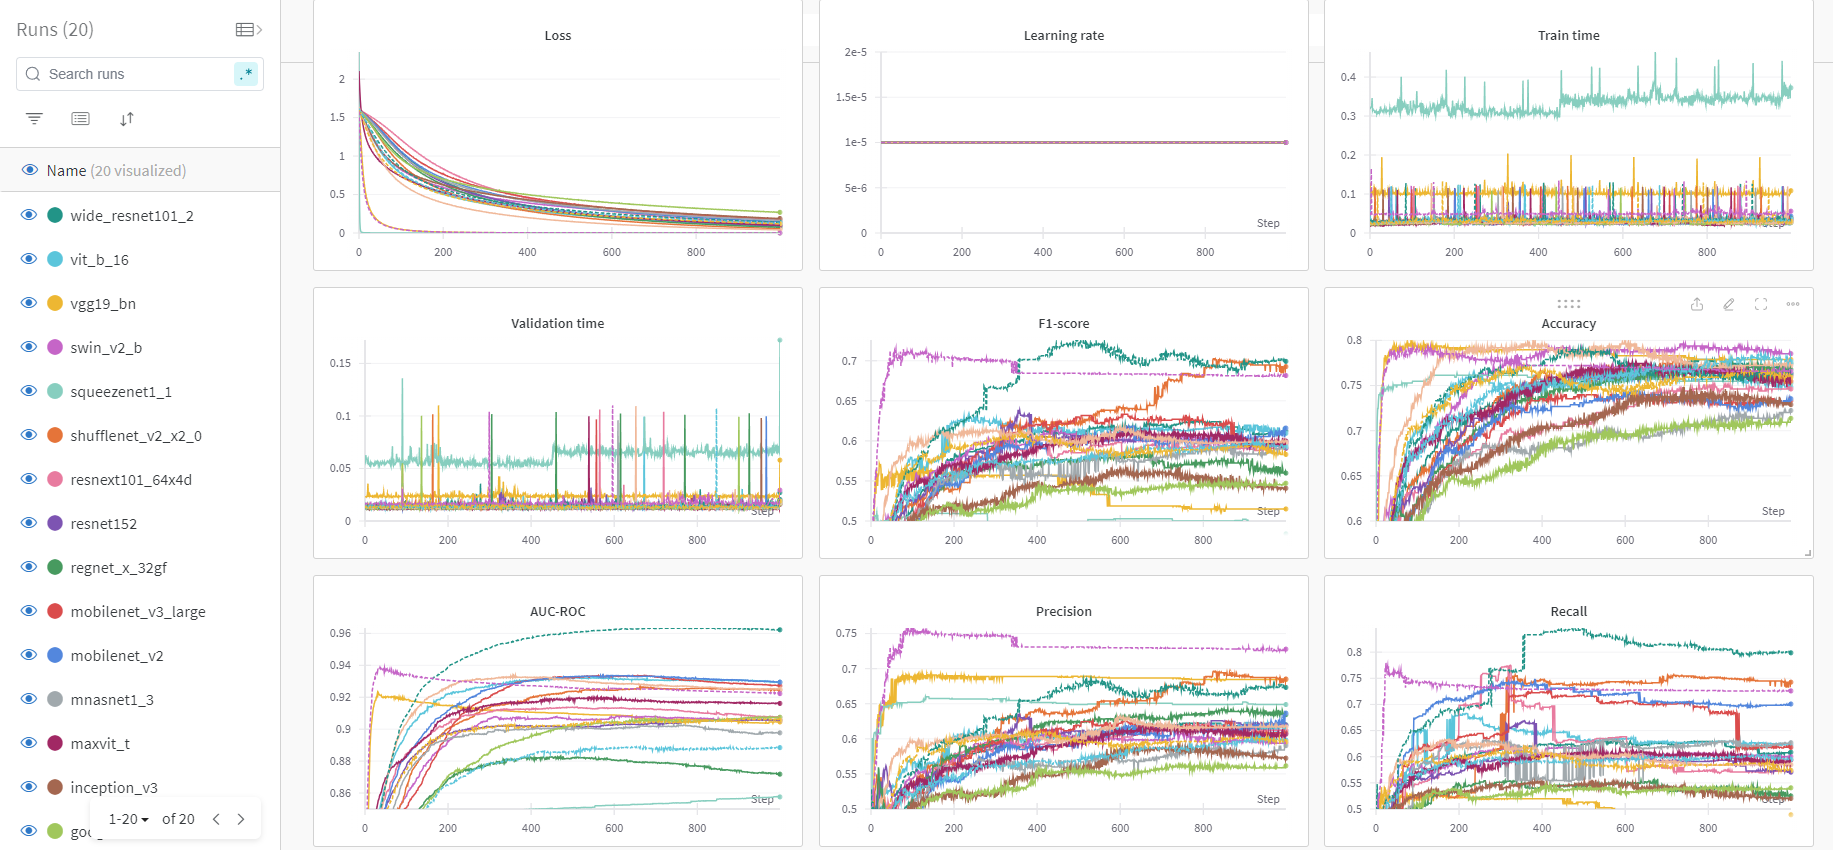

![Alternative Text][1701102140605]

[1701102140605]: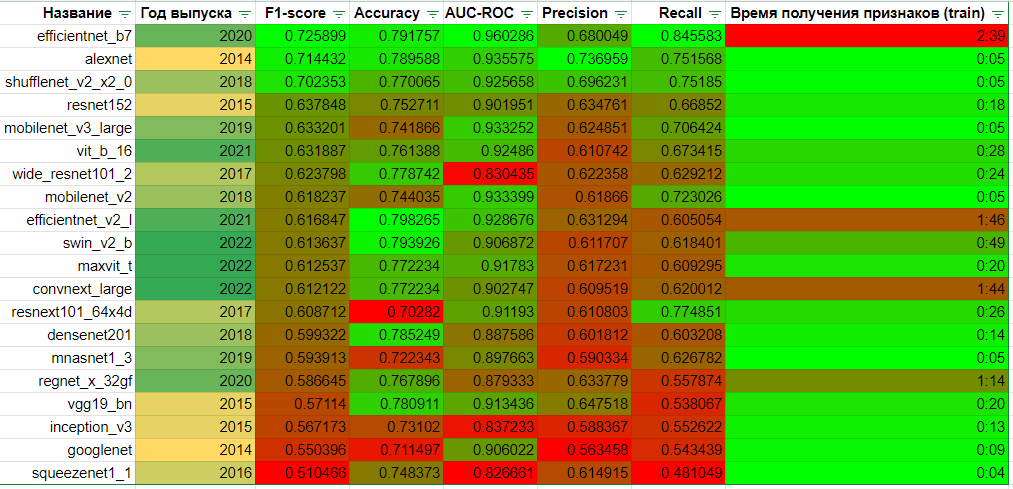

Видно, что на признаках, извлеченных моделями AlexNet и EfficientNetB7, удается достичь наилучшего качества. \
Также заметим, что классификатор над AlexNet показал наилучший Precision, а над EfficientNet - наилучший Recall. 

### Alexnet + EfficientNetB7

Возможно, если обучить классификатор на обоих признаках сразу, удастся повысить качество

In [19]:
Classifier.results = [ ]

alexnet_train_features = FeaturesDataset("alexnet", train_set, batch_size = 1024)
alexnet_test_features = FeaturesDataset("alexnet", test_set, batch_size = 1024)

effnet_train_features = FeaturesDataset("efficientnet_b7", train_set, batch_size = 16)
effnet_test_features = FeaturesDataset("efficientnet_b7", test_set, batch_size = 16)

print('AlexNet: {}'.format(alexnet_train_features[0][0].shape))
print('EfficientNet: {}'.format(effnet_train_features[0][0].shape))

# Concatenate features
train_features = FeaturesCatDataset(alexnet_train_features, effnet_train_features)
test_features = FeaturesCatDataset(alexnet_test_features, effnet_test_features)
print('AlexNet + EfficientNet: {}'.format(train_features[0][0].shape))

Features for test with efficientnet_b7: 100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


AlexNet: torch.Size([9216])
EfficientNet: torch.Size([2560])
AlexNet + EfficientNet: torch.Size([11776])


In [20]:
fix_random()
model = torch.nn.Sequential(torch.nn.LazyLinear(256), torch.nn.GELU(), torch.nn.Linear(256, 5))
Classifier('AlexNet + EfficientNet', model).fit(train_features, test_features, n_epochs = 1000).summary()

Fit AlexNet + EfficientNet: 100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.0,0.938632,0.775564,0.747113,0.732387,0.00001,0.017743,0.057061,0.00949,204


![Alternative Text][1701102293335]

[1701102293335]: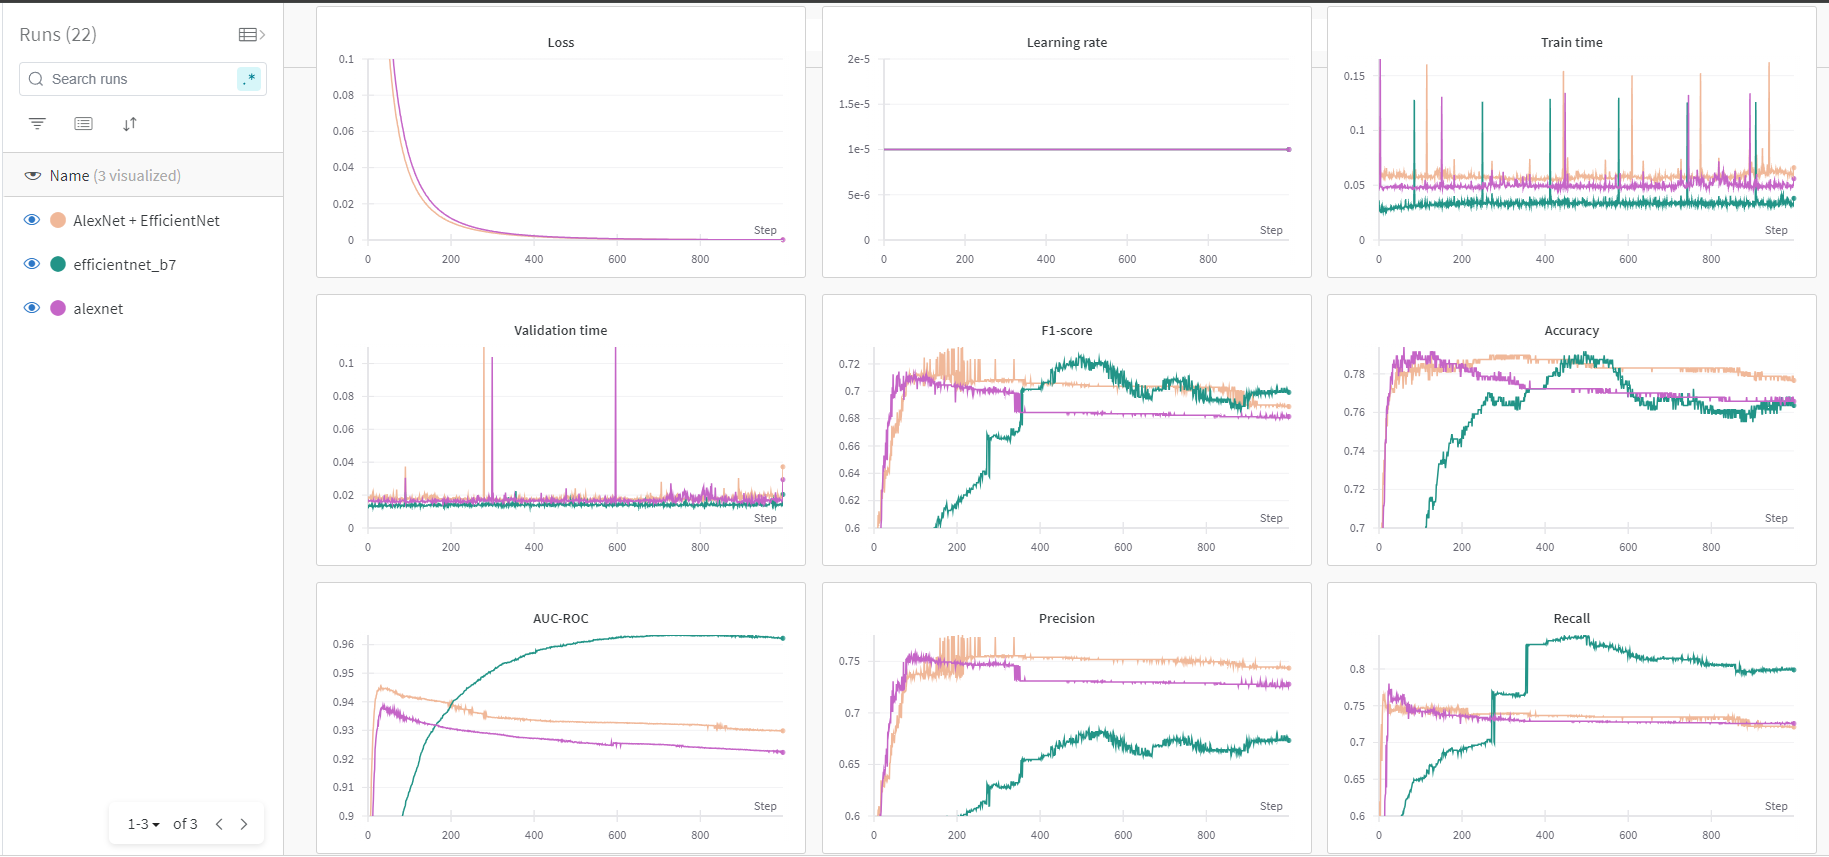

Действительно, стало лучше. Recall немного уменьшился, но Precision увеличился.

### Separate classifiers

Заметим, что AlexNet и EfficientNet извлекают разное количество признаков. Скорее всего, не очень хорошо их просто "склеивать". Попробуем обучить классификаторы отдельно для признаков, извлеченных каждой моделью, а затем объединить результаты с помощью еще одного полносвязного слоя.

In [25]:
class SeparateClassifier(torch.nn.Module):
    def __init__(self, alexnet_feature_map: torch.nn.Module, effnet_feature_map: torch.nn.Module, classifier: torch.nn.Module):
        super().__init__()
        self.classifier = classifier
        self.effnet_feature_map = effnet_feature_map
        self.alexnet_feature_map = alexnet_feature_map
    
    def forward(self, images):
        effnet = self.effnet_feature_map(images[:, 9216:])
        alexnet = self.alexnet_feature_map(images[:, :9216])
        return self.classifier(torch.cat([ alexnet, effnet ], dim = 1))

class FirstIdea(SeparateClassifier):
    def __init__(self):
        super().__init__(
            alexnet_feature_map = torch.nn.Sequential(torch.nn.LazyLinear(256)),
            effnet_feature_map = torch.nn.Sequential(torch.nn.LazyLinear(256)),
            classifier = torch.nn.Sequential(torch.nn.GELU(), torch.nn.Linear(512, 5))
        )

In [22]:
fix_random()
Classifier("FirstIdea", FirstIdea()).fit(train_features, test_features, n_epochs = 1000).summary()

Fit FirstIdea            : 100%|██████████| 1000/1000 [01:21<00:00, 12.30it/s]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.000000,0.938632,0.775564,0.747113,0.732387,0.00001,0.017743,0.057061,0.009490,204
1,FirstIdea,0.802603,0.945770,0.989154,0.997831,0.935245,0.833333,0.772348,0.781623,0.00001,0.018227,0.060135,0.019271,180


![Alternative Text][1701102366125]

[1701102366125]: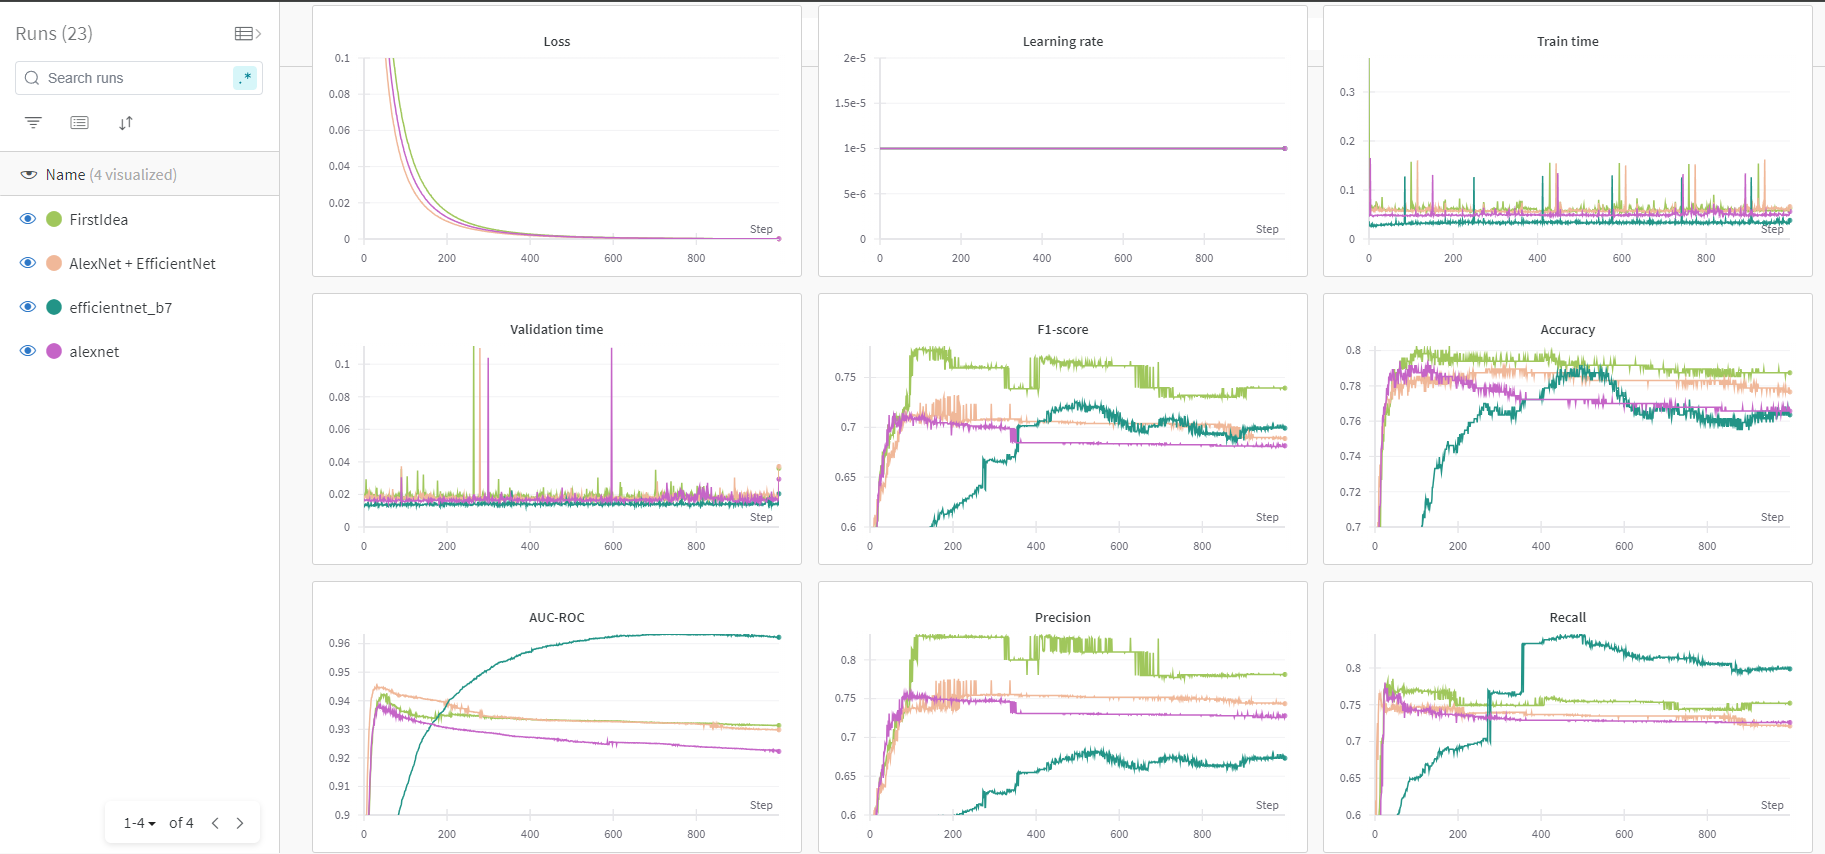

Стало гораздо лучше, но явно наблюдается переобучение.

### Dropout

Попробуем добавить Dropout. Кажется, логично это сделать перед полносвязным слоем, который получает на вход признаки, извлеченные AlexNet, так как их гораздо больше, чем признаков, извлеченных EfficientNet.

In [26]:
class DropoutIdea(SeparateClassifier):
    def __init__(self):
        super().__init__(
            alexnet_feature_map = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.LazyLinear(256)),
            effnet_feature_map = torch.nn.Sequential(torch.nn.LazyLinear(256)),
            classifier = torch.nn.Sequential(torch.nn.GELU(), torch.nn.Linear(512, 5))
        )

In [24]:
fix_random()
Classifier("DropoutIdea", DropoutIdea()).fit(train_features, test_features, n_epochs = 1000, silent = True).summary()

Fit DropoutIdea          : 100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.000000,0.938632,0.775564,0.747113,0.732387,0.00001,0.017743,0.057061,0.009490,204
1,FirstIdea,0.802603,0.945770,0.989154,0.997831,0.935245,0.833333,0.772348,0.781623,0.00001,0.018227,0.060135,0.019271,180
2,DropoutIdea,0.819957,0.945770,0.989154,1.000000,0.950652,0.893034,0.790935,0.827640,0.00001,0.017412,0.057602,0.043302,218


![Alternative Text][1701102419693]

[1701102419693]: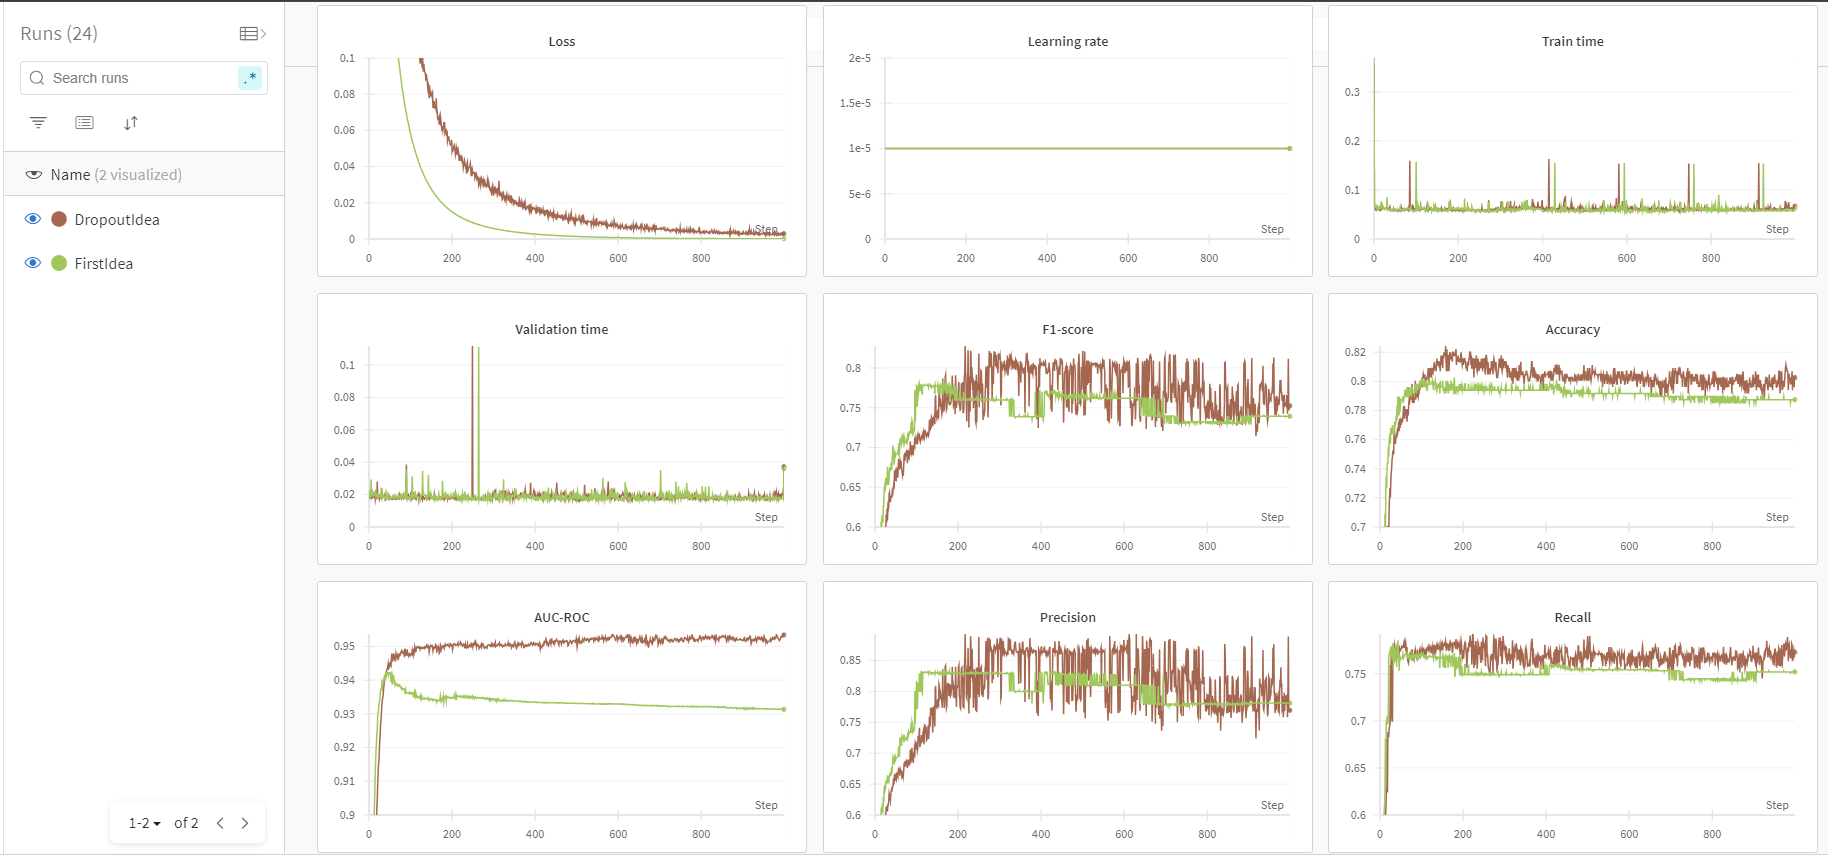

### BatchNorm

Стало заметно лучше. Попробуем добавить BatchNorm между слоями, чобы привести данные к одному масштабу после конкатенации. Кажется, это должно помочь последнему слою обучиться лучше

In [25]:
class BatchNormIdea(SeparateClassifier):
    def __init__(self):
        super().__init__(
            alexnet_feature_map = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.LazyLinear(256)),
            effnet_feature_map = torch.nn.Sequential(torch.nn.LazyLinear(256)),
            classifier = torch.nn.Sequential(torch.nn.BatchNorm1d(512), torch.nn.GELU(), torch.nn.Linear(512, 5))
        )

In [26]:
fix_random()
Classifier("BatchNormIdea", BatchNormIdea()).fit(train_features, test_features, n_epochs = 1000).summary()

Fit BatchNormIdea        : 100%|██████████| 1000/1000 [01:26<00:00, 11.61it/s]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.000000,0.938632,0.775564,0.747113,0.732387,0.00001,0.017743,0.057061,0.009490,204
1,FirstIdea,0.802603,0.945770,0.989154,0.997831,0.935245,0.833333,0.772348,0.781623,0.00001,0.018227,0.060135,0.019271,180
2,DropoutIdea,0.819957,0.945770,0.989154,1.000000,0.950652,0.893034,0.790935,0.827640,0.00001,0.017412,0.057602,0.043302,218
3,BatchNormIdea,0.815618,0.928416,0.980477,0.997831,0.966360,0.749705,0.835123,0.771277,0.00001,0.019563,0.062786,0.003562,601


![Alternative Text][1701102510566]

[1701102510566]: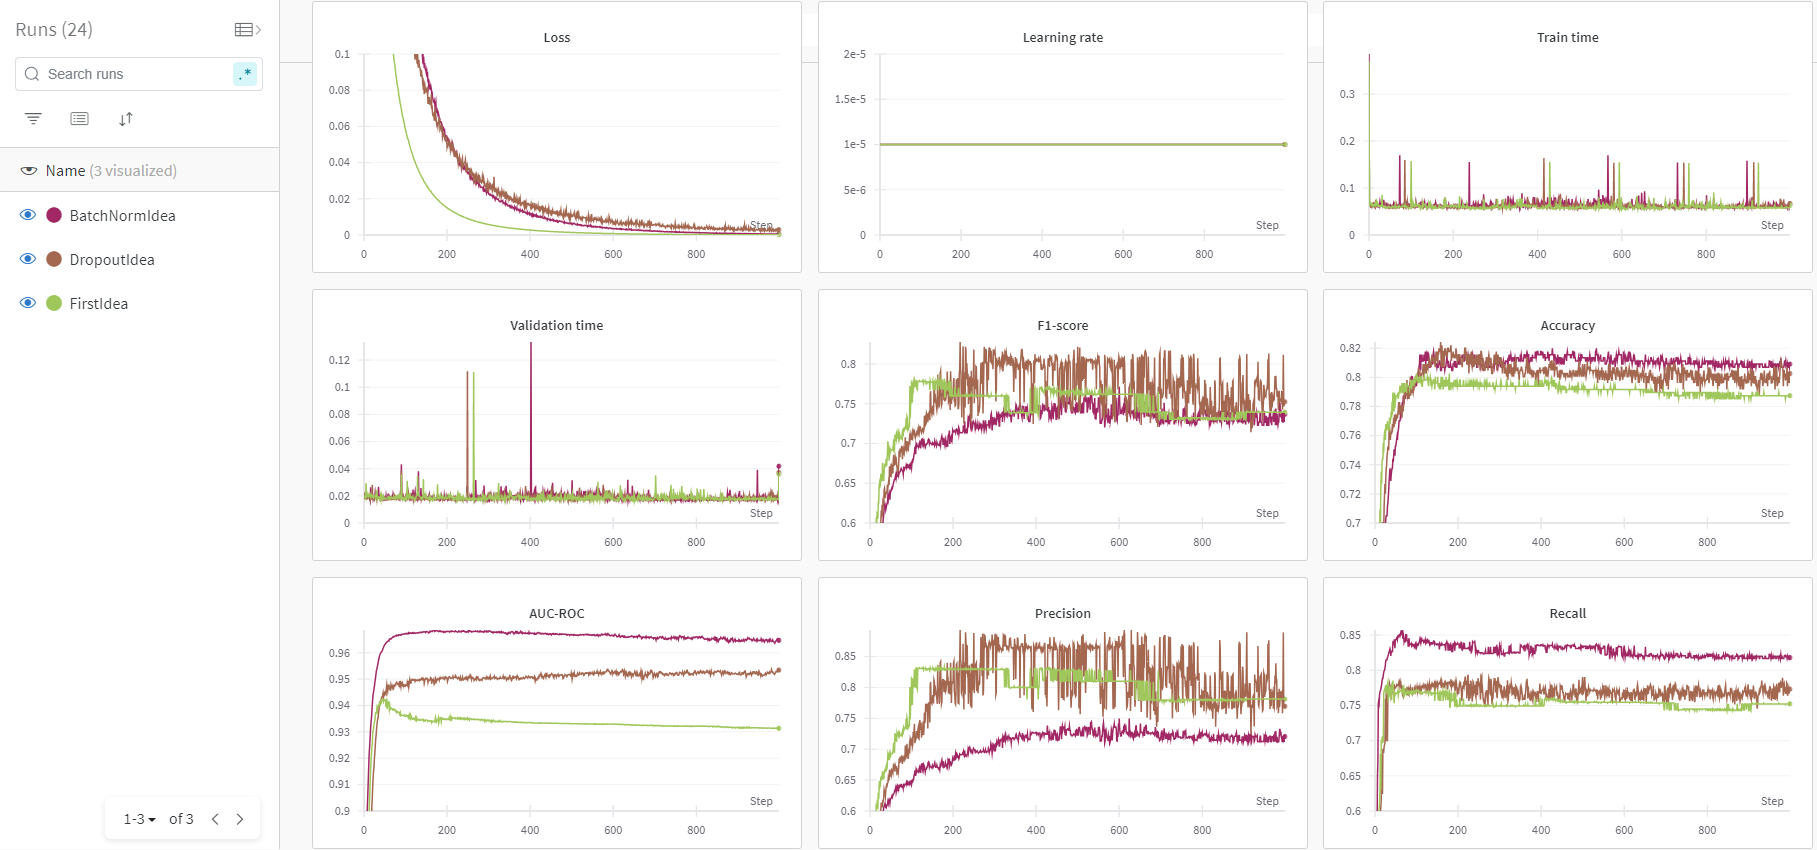

Интересно, что качество, напротив, заметно уменьшилось. Скорее всего, проблемы затухающих градиентов в модели не наблюдается \
Далее не будем ипользовать BatchNorm: скорее всего, он не приведет к значительному повышению качества даже после подбора параметров оптимзатора

### Scheduler

Заметим, что модель с Dropout при большом количестве эпох ведет себя достаточно странно: значения лосса и целевой метрики уменьшаются нестабильно. Постепенное уменьшение скорости обучения поможет улучшить процесс и, возможно, немного повысит качество

In [27]:
def lr_scheduler_lambda(epoch):
    if epoch < 10: return 10
    if epoch < 100: return 2
    if epoch < 200: return 1
    if epoch < 400: return 0.5
    if epoch < 750: return 0.25
    return 0.1

fix_random()
model = DropoutIdea().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler_lambda)
Classifier("Scheduler", model, optimizer = optimizer, scheduler = scheduler).fit(train_features, test_features, n_epochs = 1000).summary()

Fit Scheduler            : 100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.000000,0.938632,0.775564,0.747113,0.732387,0.00001,0.017743,0.057061,0.009490,204
1,FirstIdea,0.802603,0.945770,0.989154,0.997831,0.935245,0.833333,0.772348,0.781623,0.00001,0.018227,0.060135,0.019271,180
2,DropoutIdea,0.819957,0.945770,0.989154,1.000000,0.950652,0.893034,0.790935,0.827640,0.00001,0.017412,0.057602,0.043302,218
3,BatchNormIdea,0.815618,0.928416,0.980477,0.997831,0.966360,0.749705,0.835123,0.771277,0.00001,0.019563,0.062786,0.003562,601
4,Scheduler,0.819957,0.952278,0.991323,0.997831,0.952212,0.889389,0.794777,0.828955,0.00002,0.017205,0.058904,0.032094,94


![Alternative Text][1701102604894]

[1701102604894]: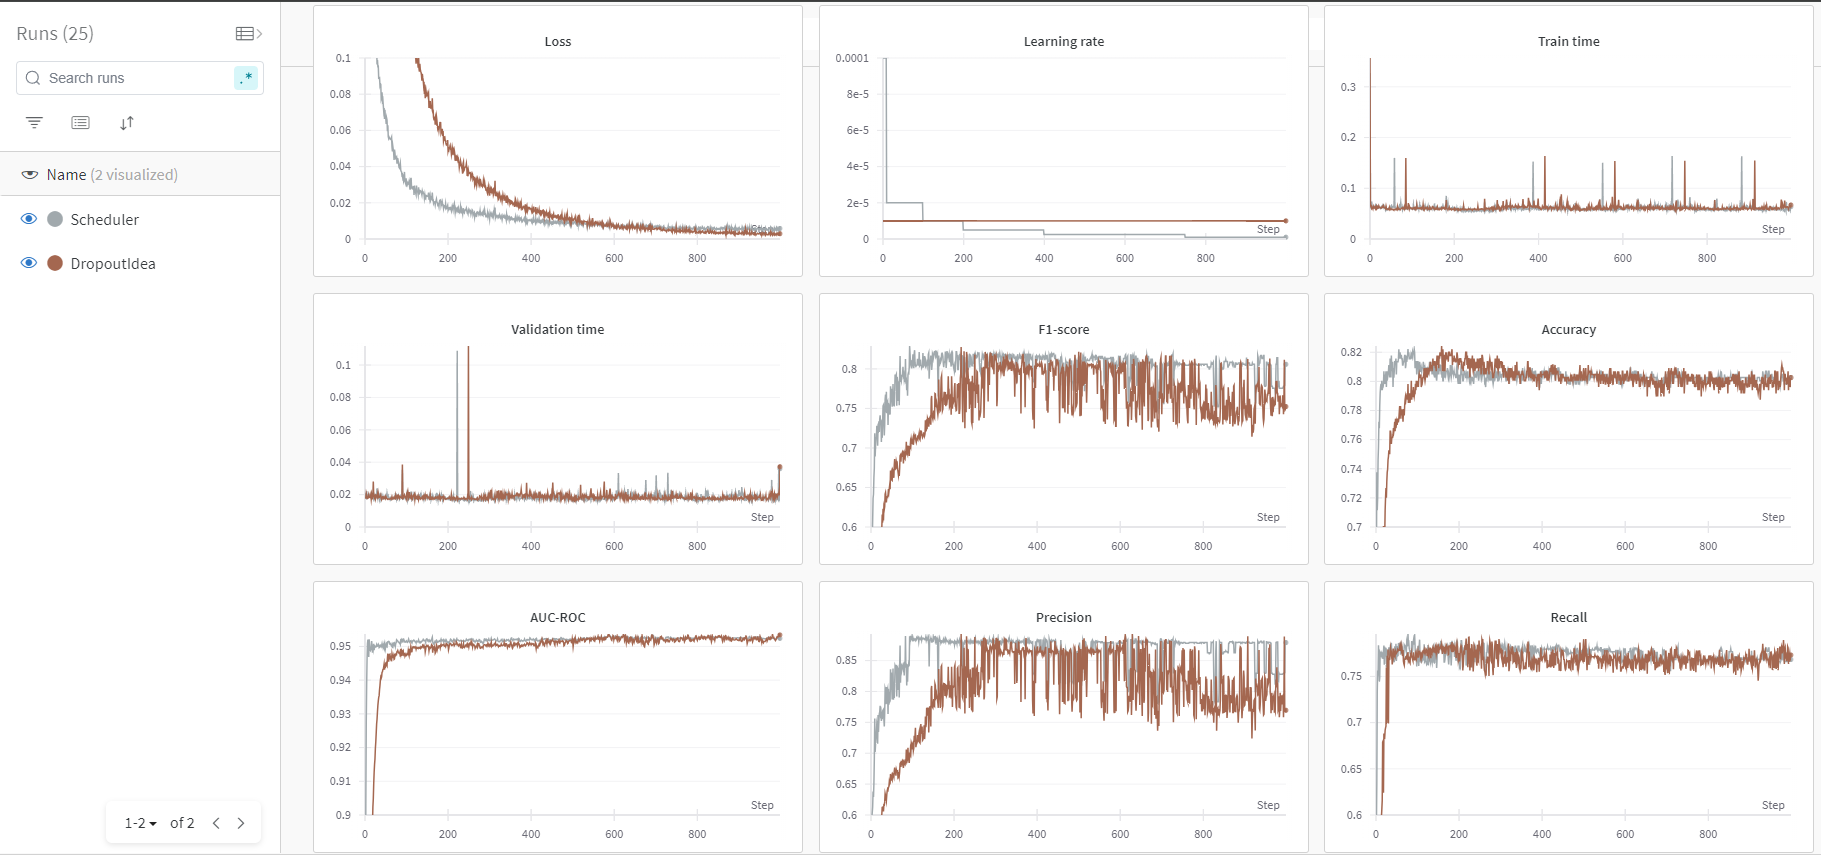

### Augmentations

Попробуем дообучить получившуюсь модель с применением аугментаций.

In [28]:
class DualDataset(torchdata.Dataset):
    def __init__(self, name: str, dataset: torchvision.datasets.ImageFolder, augmentations = None):
        self.augmentations = augmentations
        self.dataset = MyDataset(name, dataset, transform = None, preload = True, precalculate_transform = False)
        self.alexnet_transform = torchvision.models.get_model_weights("alexnet").DEFAULT.transforms()
        self.effnet_transform = torchvision.models.get_model_weights("efficientnet_b7").DEFAULT.transforms()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.augmentations: image = self.augmentations(image)
        alexnet_image = self.alexnet_transform(image)
        effnet_image = self.effnet_transform(image)
        return alexnet_image, effnet_image, label

train_set = DualDataset("train", train_images, torchvision.transforms.v2.RandAugment())
test_set = DualDataset("val", test_images)
print(train_set[0][0].shape, train_set[0][1].shape, train_set[0][2])

Preload val              : 100%|██████████| 461/461 [00:00<00:00, 1634.44it/s]


torch.Size([3, 224, 224]) torch.Size([3, 600, 600]) 0


In [29]:
class DualClassfier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        alexnet_weights = torchvision.models.get_model_weights("alexnet").DEFAULT
        effnet_weights = torchvision.models.get_model_weights("efficientnet_b7").DEFAULT
        classifier_weights = torch.load("models/Scheduler.pt")["Model"]

        self.alexnet = torchvision.models.get_model("alexnet", weights = alexnet_weights)
        self.effnet = torchvision.models.get_model("efficientnet_b7", weights = effnet_weights)
        self.classifier = DropoutIdea()
        self.classifier.load_state_dict(classifier_weights)
        
        # Remove last layer
        if hasattr(self.alexnet, 'fc'): self.alexnet.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.alexnet, 'classifier'): self.alexnet.classifier = torch.nn.Identity() # All others
        
        # Remove last layer
        if hasattr(self.effnet, 'fc'): self.effnet.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.effnet, 'classifier'): self.effnet.classifier = torch.nn.Identity() # All others

    def alexnet_features(self, images):
        return self.alexnet(images)
    
    def effnet_features(self, images):
        return self.effnet(images)

    def forward(self, alexnet_images, effnet_images):
        alexnet_features = self.alexnet_features(alexnet_images)
        effnet_features = self.effnet_features(effnet_images)
        features = torch.cat([ alexnet_features, effnet_features ], dim = 1)
        return self.classifier(features)

In [30]:
class AugmentedClassifier(DualClassfier):
    def alexnet_features(self, images):
        self.alexnet.eval()
        with torch.no_grad():
            return super().alexnet_features(images)
    
    def effnet_features(self, images):
        self.effnet.eval()
        with torch.no_grad():
            return super().effnet_features(images)

Проверим, что все веса загрузились правильно и значение метрики совпадает с полученным ранее

In [31]:
classifier = Classifier("AugmentedClassifier", AugmentedClassifier(), batch_size = 16)
classifier.output_shape = (5,)
classifier.calc_metrics(test_set)

{'Accuracy': 0.8199566160520607,
 'TOP-2 Accuracy': 0.9522776572668112,
 'TOP-3 Accuracy': 0.9913232104121475,
 'TOP-4 Accuracy': 0.9978308026030369,
 'AUC-ROC': 0.95221153903345,
 'Precision': 0.8893892127426465,
 'Recall': 0.7947765233260935,
 'F1-score': 0.8289547053249736}

Попробуем обучить несколько эпох. Если улучшение модели возможно, это будет видно сразу

In [32]:
fix_random()
classifier = Classifier("AugmentedClassifier", AugmentedClassifier(), learning_rate = 5e-7, batch_size = 16)
classifier.fit(train_set, test_set, n_epochs = 3).summary()

Fit AugmentedClassifier  : 100%|██████████| 3/3 [10:09<00:00, 203.22s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.000000,0.938632,0.775564,0.747113,0.732387,1.000000e-05,0.017743,0.057061,0.009490,204
1,FirstIdea,0.802603,0.945770,0.989154,0.997831,0.935245,0.833333,0.772348,0.781623,1.000000e-05,0.018227,0.060135,0.019271,180
2,DropoutIdea,0.819957,0.945770,0.989154,1.000000,0.950652,0.893034,0.790935,0.827640,1.000000e-05,0.017412,0.057602,0.043302,218
3,BatchNormIdea,0.815618,0.928416,0.980477,0.997831,0.966360,0.749705,0.835123,0.771277,1.000000e-05,0.019563,0.062786,0.003562,601
4,Scheduler,0.819957,0.952278,0.991323,0.997831,0.952212,0.889389,0.794777,0.828955,2.000000e-05,0.017205,0.058904,0.032094,94
5,AugmentedClassifier,0.798265,0.945770,0.986985,0.997831,0.954688,0.715853,0.784730,0.717285,5.000000e-07,33.815122,166.590178,0.439527,1


Повышения качества явно не наблюдается.

### Train AlexNet and some layers of EfficientNet

Попробуем дообучить сами AlexNet и EfficientNet. Для EfficientNet будем обучать только два последних слоя: модель слишком большая, чтобы обучать целиком. Этого должно быть достаточно, чтобы увидеть повышение качества, если оно будет.

#### Only AlexNet

In [33]:
class TrainAlexnetClassifier(DualClassfier):
    def effnet_features(self, images):
        self.effnet.eval()
        with torch.no_grad():
            return super().effnet_features(images)

In [34]:
classifier = Classifier("TrainAlexnetClassifier", TrainAlexnetClassifier(), batch_size = 16)
classifier.output_shape = (5,)
classifier.calc_metrics(test_set)

{'Accuracy': 0.8199566160520607,
 'TOP-2 Accuracy': 0.9522776572668112,
 'TOP-3 Accuracy': 0.9913232104121475,
 'TOP-4 Accuracy': 0.9978308026030369,
 'AUC-ROC': 0.95221153903345,
 'Precision': 0.8893892127426465,
 'Recall': 0.7947765233260935,
 'F1-score': 0.8289547053249736}

In [35]:
fix_random()
classifier = Classifier("TrainAlexnetClassifier", TrainAlexnetClassifier(), learning_rate = 5e-7, batch_size = 16)
classifier.fit(train_set, test_set, n_epochs = 3).summary()

Fit TrainAlexnetClassifier: 100%|██████████| 3/3 [10:16<00:00, 205.63s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.000000,0.938632,0.775564,0.747113,0.732387,1.000000e-05,0.017743,0.057061,0.009490,204
1,FirstIdea,0.802603,0.945770,0.989154,0.997831,0.935245,0.833333,0.772348,0.781623,1.000000e-05,0.018227,0.060135,0.019271,180
2,DropoutIdea,0.819957,0.945770,0.989154,1.000000,0.950652,0.893034,0.790935,0.827640,1.000000e-05,0.017412,0.057602,0.043302,218
3,BatchNormIdea,0.815618,0.928416,0.980477,0.997831,0.966360,0.749705,0.835123,0.771277,1.000000e-05,0.019563,0.062786,0.003562,601
4,Scheduler,0.819957,0.952278,0.991323,0.997831,0.952212,0.889389,0.794777,0.828955,2.000000e-05,0.017205,0.058904,0.032094,94
5,AugmentedClassifier,0.798265,0.945770,0.986985,0.997831,0.954688,0.715853,0.784730,0.717285,5.000000e-07,33.815122,166.590178,0.439527,1
6,TrainAlexnetClassifier,0.787419,0.941432,0.984816,0.997831,0.956448,0.674376,0.772231,0.682489,5.000000e-07,34.097935,170.433146,0.424778,1


#### Only EfficientNet

In [36]:
class TrainEffnetClassifier(DualClassfier):
    def __init__(self):
        super().__init__()
        for feature in range(0, 7):
            for parameter in self.effnet.features[feature].parameters():
                parameter.requires_grad = False

    def alexnet_features(self, images):
        self.alexnet.eval()
        with torch.no_grad():
            return super().alexnet_features(images)
    
    def effnet_features(self, images):
        for feature in range(0, 7):
            self.effnet.features[feature].eval()
        return super().effnet_features(images)

In [37]:
classifier = Classifier("TrainEffnetClassifier", TrainEffnetClassifier(), batch_size = 16)
classifier.output_shape = (5,)
classifier.calc_metrics(test_set)

{'Accuracy': 0.8199566160520607,
 'TOP-2 Accuracy': 0.9522776572668112,
 'TOP-3 Accuracy': 0.9913232104121475,
 'TOP-4 Accuracy': 0.9978308026030369,
 'AUC-ROC': 0.95221153903345,
 'Precision': 0.8893892127426465,
 'Recall': 0.7947765233260935,
 'F1-score': 0.8289547053249736}

In [38]:
fix_random()
classifier = Classifier("TrainEffnetClassifier", TrainEffnetClassifier(), learning_rate = 5e-7, batch_size = 16)
classifier.fit(train_set, test_set, n_epochs = 3).summary()

Fit TrainEffnetClassifier: 100%|██████████| 3/3 [11:44<00:00, 234.86s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.000000,0.938632,0.775564,0.747113,0.732387,1.000000e-05,0.017743,0.057061,0.009490,204
1,FirstIdea,0.802603,0.945770,0.989154,0.997831,0.935245,0.833333,0.772348,0.781623,1.000000e-05,0.018227,0.060135,0.019271,180
2,DropoutIdea,0.819957,0.945770,0.989154,1.000000,0.950652,0.893034,0.790935,0.827640,1.000000e-05,0.017412,0.057602,0.043302,218
3,BatchNormIdea,0.815618,0.928416,0.980477,0.997831,0.966360,0.749705,0.835123,0.771277,1.000000e-05,0.019563,0.062786,0.003562,601
4,Scheduler,0.819957,0.952278,0.991323,0.997831,0.952212,0.889389,0.794777,0.828955,2.000000e-05,0.017205,0.058904,0.032094,94
5,AugmentedClassifier,0.798265,0.945770,0.986985,0.997831,0.954688,0.715853,0.784730,0.717285,5.000000e-07,33.815122,166.590178,0.439527,1
6,TrainAlexnetClassifier,0.787419,0.941432,0.984816,0.997831,0.956448,0.674376,0.772231,0.682489,5.000000e-07,34.097935,170.433146,0.424778,1
7,TrainEffnetClassifier,0.737527,0.928416,0.984816,0.995662,0.936341,0.759367,0.761270,0.751232,5.000000e-07,33.581684,201.901335,0.511304,1


#### Both

In [39]:
class TrainBothClassifier(DualClassfier):
    def __init__(self):
        super().__init__()
        for feature in range(0, 7):
            for parameter in self.effnet.features[feature].parameters():
                parameter.requires_grad = False
    
    def effnet_features(self, images):
        for feature in range(0, 7):
            self.effnet.features[feature].eval()
        return super().effnet_features(images)

In [40]:
classifier = Classifier("TrainBothClassifier", TrainBothClassifier(), batch_size = 16)
classifier.output_shape = (5,)
classifier.calc_metrics(test_set)

{'Accuracy': 0.8199566160520607,
 'TOP-2 Accuracy': 0.9522776572668112,
 'TOP-3 Accuracy': 0.9913232104121475,
 'TOP-4 Accuracy': 0.9978308026030369,
 'AUC-ROC': 0.95221153903345,
 'Precision': 0.8893892127426465,
 'Recall': 0.7947765233260935,
 'F1-score': 0.8289547053249736}

In [41]:
fix_random()
classifier = Classifier("TrainBothClassifier", TrainBothClassifier(), learning_rate = 5e-7, batch_size = 16)
classifier.fit(train_set, test_set, n_epochs = 3).summary()

Fit TrainBothClassifier  : 100%|██████████| 3/3 [12:58<00:00, 259.44s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,AlexNet + EfficientNet,0.787419,0.937093,0.982646,1.000000,0.938632,0.775564,0.747113,0.732387,1.000000e-05,0.017743,0.057061,0.009490,204
1,FirstIdea,0.802603,0.945770,0.989154,0.997831,0.935245,0.833333,0.772348,0.781623,1.000000e-05,0.018227,0.060135,0.019271,180
2,DropoutIdea,0.819957,0.945770,0.989154,1.000000,0.950652,0.893034,0.790935,0.827640,1.000000e-05,0.017412,0.057602,0.043302,218
3,BatchNormIdea,0.815618,0.928416,0.980477,0.997831,0.966360,0.749705,0.835123,0.771277,1.000000e-05,0.019563,0.062786,0.003562,601
4,Scheduler,0.819957,0.952278,0.991323,0.997831,0.952212,0.889389,0.794777,0.828955,2.000000e-05,0.017205,0.058904,0.032094,94
5,AugmentedClassifier,0.798265,0.945770,0.986985,0.997831,0.954688,0.715853,0.784730,0.717285,5.000000e-07,33.815122,166.590178,0.439527,1
6,TrainAlexnetClassifier,0.787419,0.941432,0.984816,0.997831,0.956448,0.674376,0.772231,0.682489,5.000000e-07,34.097935,170.433146,0.424778,1
7,TrainEffnetClassifier,0.737527,0.928416,0.984816,0.995662,0.936341,0.759367,0.761270,0.751232,5.000000e-07,33.581684,201.901335,0.511304,1
8,TrainBothClassifier,0.735358,0.924078,0.984816,0.995662,0.940393,0.676843,0.753531,0.687665,5.000000e-07,37.860331,223.182811,0.495010,1


![Alternative Text][1701105503481]

[1701105503481]: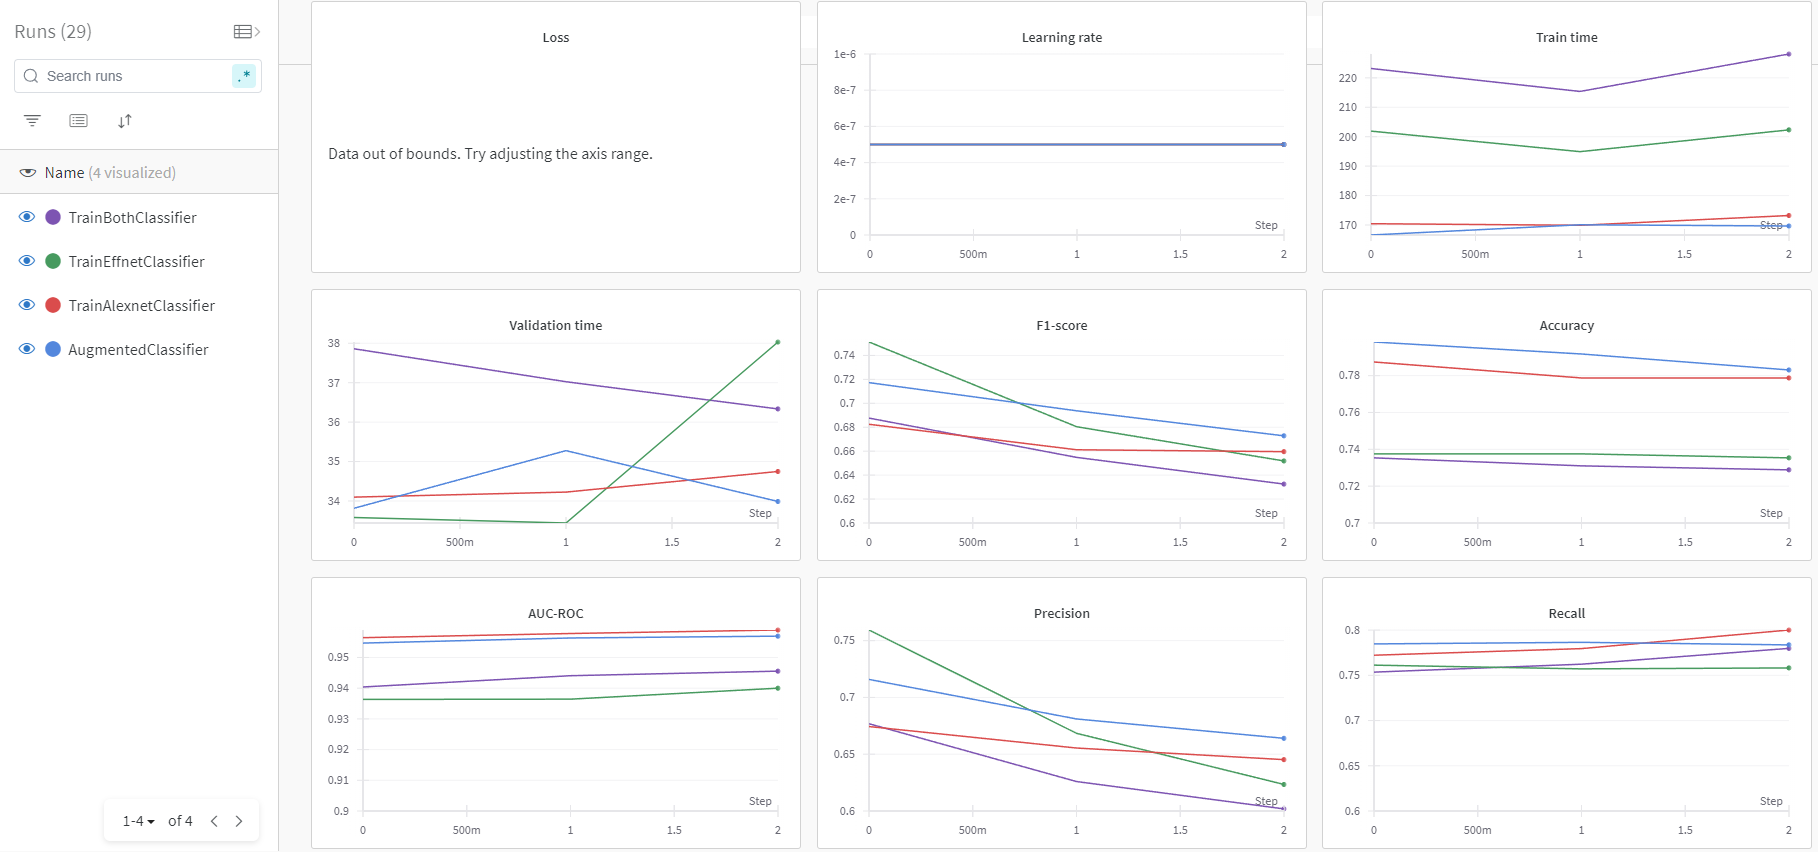

Попытки дообучения модели таким образом результатов не дали. Наилучшее достигнутое качество остаётся 0.83.

### Own ResNet

Попробуем обучить свою реализацию ResNet с нуля. Может быть, готовые модели из torchvision всё-таки не очень хорошо подходят для этого датасета.

In [16]:
class BasicBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        stride = out_channels // in_channels

        self.direct = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, stride = stride),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(out_channels)
        )
        
        if stride != 1:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride),
                torch.nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = torch.nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.relu(self.direct(x) + self.shortcut(x))

In [17]:
def make_blocks(in_channels: int, out_channels: int):
    return torch.nn.Sequential(
        BasicBlock(in_channels, out_channels),
        BasicBlock(out_channels, out_channels),
        BasicBlock(out_channels, out_channels)
    )

def CustomResNet() -> torch.nn.Module:
    return torch.nn.Sequential(
        torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size = 7, padding = 3, stride = 2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        ),

        make_blocks(64, 128),
        make_blocks(128, 256),
        make_blocks(256, 512),
        
        torch.nn.AdaptiveAvgPool2d((1, 1)),
        torch.nn.Flatten(),
        torch.nn.LazyLinear(5)
    )

In [18]:
torchscan.summary(CustomResNet(), (3, 224, 224), receptive_field = True)

d:\Programs\Programming\Python\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
d:\Programs\Programming\Python\Lib\site-packages\torchscan\modules\flops.py:64: UserWarning: Module type not supported: Flatten
  warnings.warn(f'Module type not supported: {module.__class__.__name__}')
d:\Programs\Programming\Python\Lib\site-packages\torchscan\modules\macs.py:51: UserWarning: Module type not supported: Flatten
  warnings.warn(f'Module type not supported: {module.__class__.__name__}')
d:\Programs\Programming\Python\Lib\site-packages\torchscan\modules\memory.py:57: UserWarning: Module type not supported: Flatten
  warnings.warn(f'Module type not supported: {module.__class__.__name__}')
d:\Programs\Programming\Python\Lib\site-packages\torchscan\modules\receptive.py:46: UserWarning: Module t

____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 5)                   0               4737           
├─0                          Sequential            (-1, 64, 56, 56)          0               4737           
|    └─0                     Conv2d                (-1, 64, 112, 112)        9,472           4737           
|    └─1                     BatchNorm2d           (-1, 64, 112, 112)        257             2366           
|    └─2                     ReLU                  (-1, 64, 112, 112)        0               2366           
|    └─3                     MaxPool2d             (-1, 64, 56, 56)          0               2366           
├─1                          Sequential            (-1, 128, 28, 28)         0               1183           
|    └─0           

d:\Programs\Programming\Python\Lib\site-packages\torchscan\process\memory.py:32: UserWarning: raised: could not convert string to float: ''. Assuming no GPU is available.
  warnings.warn(f"raised: {e}. Assuming no GPU is available.")


In [19]:
fix_random()

transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize(224),
    torchvision.transforms.v2.CenterCrop((224, 224)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
test_set = MyDataset("val", test_images, transform = transform, preload = True, precalculate_transform = True)

Preload val              : 100%|██████████| 461/461 [00:00<00:00, 526.25it/s]


In [20]:
Classifier.results = [ ]

In [21]:
def lr_scheduler_lambda(epoch):
    if epoch < 15: return 1
    return 0.1

fix_random()
model = CustomResNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler_lambda)
classifier = Classifier("CustomResNet", model, optimizer = optimizer, scheduler = scheduler, batch_size = 128)
classifier.fit(train_set, test_set).summary()

Fit CustomResNet         : 100%|██████████| 25/25 [03:06<00:00,  7.48s/it]


,Name,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,AUC-ROC,Precision,Recall,F1-score,Learning rate,Validation time,Train time,Loss,Epoch
0,CustomResNet,0.618221,0.852495,0.980477,0.984816,0.668003,0.471174,0.46379,0.461877,0.0001,0.522596,6.909461,0.368752,24


Ожидаемо, эксперимент оказался неудачным: хорошего качества достичь не удалось

# Report

In [28]:
test_set = MyDataset("val", test_images, transform = None, preload = True, precalculate_transform = True)
alexnet_test_features = FeaturesDataset("alexnet", test_set, batch_size = 1024)
effnet_test_features = FeaturesDataset("efficientnet_b7", test_set, batch_size = 16)
test_features = FeaturesCatDataset(alexnet_test_features, effnet_test_features)

classifier_weights = torch.load("models/Scheduler.pt")["Model"]
model = DropoutIdea()
model.load_state_dict(classifier_weights)
classifier = Classifier("Final model", model, batch_size = 1024)
classifier.output_shape = (5,)
classifier.calc_metrics(test_features)

Features for val with efficientnet_b7: 100%|██████████| 29/29 [00:32<00:00,  1.13s/it]
d:\Programs\Programming\Python\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


{'Accuracy': 0.8199566160520607,
 'TOP-2 Accuracy': 0.9522776572668112,
 'TOP-3 Accuracy': 0.9913232104121475,
 'TOP-4 Accuracy': 0.9978308026030369,
 'AUC-ROC': 0.95221153903345,
 'Precision': 0.8893892127426465,
 'Recall': 0.7947765233260935,
 'F1-score': 0.8289547053249736}

В ходе экспериментов мне удалось достичь лучшего значения F1-меры почти `0.83`. При этом модель верно предсказывает класс для почти 82% объектов, а верный класс оказывается среди двух наиболее вероятных в более, чем 95% случаев. \
Было выявлено, что для достижения хорошего качества следует использовать готовые предобученные модели, а не обучать архитектуру с нуля. Более того, для решения данной задачи достаточно обучить только последний слой, а попытки дообучать остальные слои не привели к улучшению качества модели. \
Также хочу отметить, что достаточно интересная идея объединения AlexNet и EfficientNet в одну модель путём конкатенации векторов признаков, работает очень хорошо и позволяет значительно повысить качество в сравнении с классификатором над признаками, извлекаемыми только одной моделью.